<a href="https://colab.research.google.com/github/atharvakale31/PR_ML/blob/master/Bayes_Factors_and_Marginal_Likelihood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://docs.pymc.io/notebooks/Bayes_factor.html

In [ ]:
import arviz as az
import numpy as np
import pymc3 as pm

from matplotlib import pyplot as plt
from scipy.special import betaln
from scipy.stats import beta

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [ ]:
az.style.use("arviz-darkgrid")

The “Bayesian way” to compare models is to compute the marginal likelihood of each model p(y∣Mk), i.e. the probability of the observed data y given the Mk model. 

# Bayesian model selection


*  Sometimes the main objective is not to just keep a single model but instead to compare models to determine which ones are more likely and by how much. This can be achieved using Bayes factors:
*   BF=p(y∣M0)/p(y∣M1)
* The larger the BF the better the model in the numerator (M0 in this example). To ease the interpretation of BFs some authors have proposed tables with levels of support or strength, just a way to put numbers into words.

>1-3: anecdotal

>3-10: moderate

>10-30: strong

> 30-100: very strong

> 100: extreme


In [ ]:
def beta_binom(prior, y):
    """
    Compute the marginal likelihood, analytically, for a beta-binomial model.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    y : array
        array with "1" and "0" corresponding to the success and fails respectively
    """
    alpha, beta = prior
    h = np.sum(y)
    n = len(y)
    p_y = np.exp(betaln(alpha + h, beta + n - h) - betaln(alpha, beta))
    return p_y

In [ ]:
y = np.repeat([1, 0], [50, 50])  # 50 "heads" and 50 "tails"
priors = ((1, 1), (30, 30))

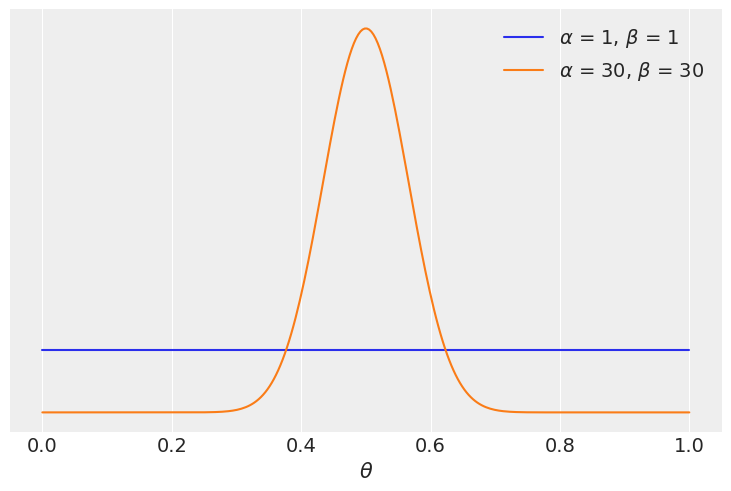

In [ ]:
for a, b in priors:
    distri = beta(a, b)
    x = np.linspace(0, 1, 300)
    x_pdf = distri.pdf(x)
    plt.plot(x, x_pdf, label=fr"$\alpha$ = {a:d}, $\beta$ = {b:d}")
    plt.yticks([])
    plt.xlabel("$\\theta$")
    plt.legend()

In [ ]:
BF = beta_binom(priors[1], y) / beta_binom(priors[0], y)
print(round(BF))

5


We see that the model with the more concentrated prior beta(30,30) has ≈5 times more support than the model with the more extended prior beta(1,1)

In [ ]:
models = []
traces = []
for alpha, beta in priors:
    with pm.Model() as model:
        a = pm.Beta("a", alpha, beta)
        yl = pm.Bernoulli("yl", a, observed=y)
        trace = pm.sample_smc(1000, random_seed=42, parallel=True)
        models.append(model)
        traces.append(trace)

Initializing SMC sampler...
Sampling 2 chains in 1 job
Stage:   0 Beta: 0.107
Stage:   1 Beta: 0.891
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 1 job
Stage:   0 Beta: 1.000


In [ ]:
BF_smc = np.exp(traces[1].report.log_marginal_likelihood - traces[0].report.log_marginal_likelihood)
np.round(BF_smc)

array([5., 5.])

## Bayes factors and inference

In [ ]:
az.summary(traces[0], var_names="a", kind="stats").round(2)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.5,0.05,0.4,0.58


In [ ]:
az.summary(traces[1], var_names="a", kind="stats").round(2)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.5,0.04,0.42,0.57


/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


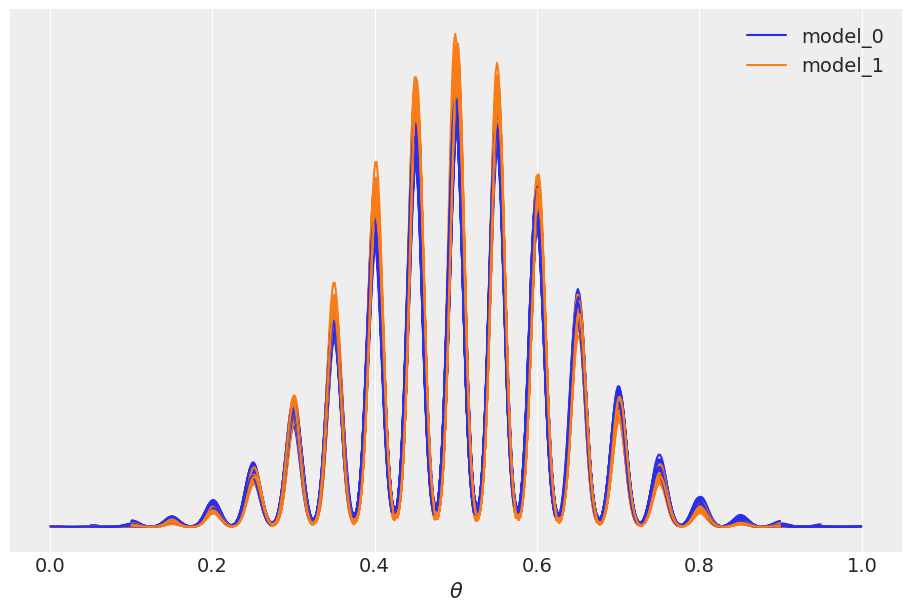

In [ ]:
_, ax = plt.subplots(figsize=(9, 6))
ppc_0 = pm.sample_posterior_predictive(traces[0], 100, models[0], size=(len(y), 20))
ppc_1 = pm.sample_posterior_predictive(traces[1], 100, models[1], size=(len(y), 20))
for m_0, m_1 in zip(ppc_0["yl"].T, ppc_1["yl"].T):
    az.plot_kde(np.mean(m_0, 0), ax=ax, plot_kwargs={"color": "C0"})
    az.plot_kde(np.mean(m_1, 0), ax=ax, plot_kwargs={"color": "C1"})
ax.plot([], label="model_0")
ax.plot([], label="model_1")
ax.legend()
ax.set_xlabel("$\\theta$")
ax.set_yticks([]);

Baye's Factor : O. Martin

In [ ]:
coins = 30 
heads = 9
y_d = np.repeat([0, 1], [coins-heads, heads]) 

In [ ]:
with pm.Model() as model_BF: 
  p = np.array([0.5, 0.5])
  model_index = pm.Categorical('model_index', p=p)
  m_0 = (4, 8) 
  m_1 = (8, 4)
  m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)
  # a priori 
  θ = pm.Beta('θ', m[0], m[1]) 
  y = pm.Bernoulli('y', θ, observed=y_d) # likelihood
  trace_BF = pm.sample(5000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # Remove the CWD from sys.path while we load stuff.
Sequential sampling (2 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [model_index]
>NUTS: [θ]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd1ad2bd10>,
      dtype=object)

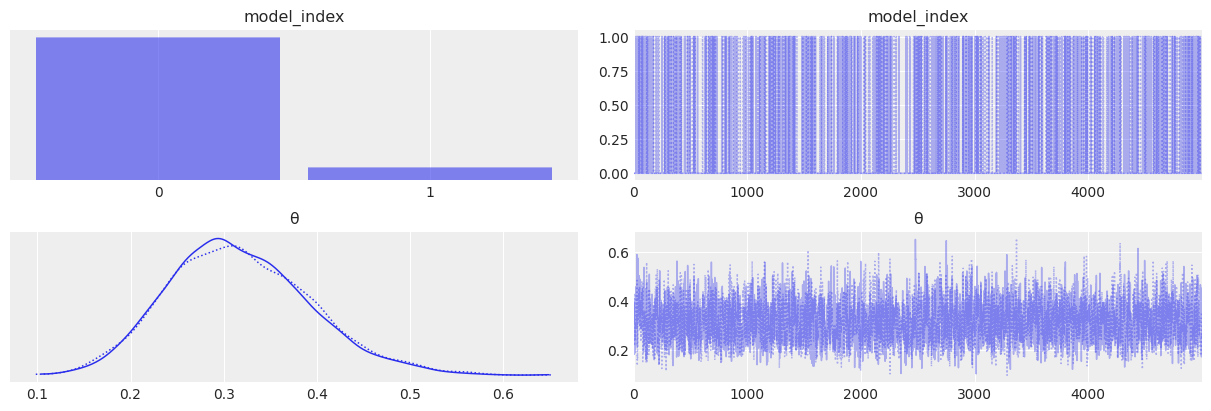

In [ ]:
az.plot_trace(trace_BF)

In [ ]:
pM1 = trace_BF['model_index'].mean() 
pM0 = 1 - pM1
BF = (pM0 / pM1) * (p[1] / p[0])

In [ ]:
BF

11.121212121212121

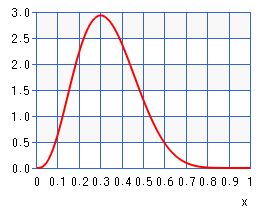
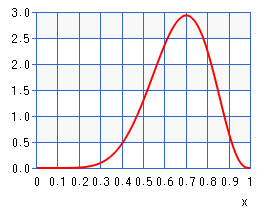

In [ ]:
with pm.Model() as model_BF_0: 
  θ = pm.Beta('θ', 4, 8) 
  y = pm.Bernoulli('y', θ, observed=y_d) 
  trace_BF_0 = pm.sample_smc(2500)
with pm.Model() as model_BF_1: 
  θ = pm.Beta('θ', 8, 4) 
  y = pm.Bernoulli('y', θ, observed=y_d) 
  trace_BF_1 = pm.sample_smc(2500)



Initializing SMC sampler...
Sampling 2 chains in 1 job
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 1 job
Stage:   0 Beta: 0.198
Stage:   1 Beta: 0.644
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.204
Stage:   1 Beta: 0.666
Stage:   2 Beta: 1.000


In [ ]:
BF_smc = np.exp(trace_BF_0.report.log_marginal_likelihood - trace_BF_1.report.log_marginal_likelihood)
BF_smc

array([11.52130734, 11.20938369])

In [ ]:
az.summary(trace_BF_0)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.309,0.07,0.173,0.433,0.001,0.001,4840.0,4904.0,1.0


In [ ]:
az.summary(trace_BF_1)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.405,0.075,0.265,0.544,0.001,0.001,4844.0,4301.0,1.0
